## Crop the train and test data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ext = 'drive/MyDrive/CV_Images/'#concentric.mat'

In [3]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 15.5 MB/s 


In [4]:
import cv2
import numpy as np
import json
import os
import random
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.applications.resnet import preprocess_input
import tensorflow_addons as tfa
import seaborn as sns

In [5]:
path = '/content/drive/MyDrive/CV_Images'

In [6]:
# def data_loader(path, data_name, img_size): # data_name = 'cropped_train', # img_size = 128 
#   all_images = []
#   #{'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1039':5, '1017':6,'1021':7}
#   all_files = ['1040','1019', '1015', '1004', '1005','1039','1017','1021','1001','1007','1018']#,'1021'] # ['1015','1019'] # for now manually changed as issue in 1021, 1040 #'1004', '1005','1019',
#   for label_folder in all_files:
#     inside_path = path+'/'+ label_folder +'/'+ data_name
#     fold = os.listdir(inside_path)
#     for img  in fold:
#       ext = os.path.splitext(img)[-1]
#       if ext in ['.jpg', '.JPG']: # only jpg files no json files
#         try:
#           img_arr = cv2.imread(os.path.join(inside_path, img))
#           #print(img_arr.shape)
#           new_arr = cv2.resize(img_arr, (img_size, img_size)) 
#           all_images.append([new_arr, label_folder])  
#         except:
#           pass 
#     #print(label_folder,data_name,len(all_images))
#     random.shuffle(all_images)
#   return all_images

def data_loader(path, data_name, img_size): # data_name = 'cropped_train', # img_size = 128 
  all_images,img_files = [],[]

  #{'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1039':5, '1017':6,'1021':7}
  #1002']:#['1037','1031','1020','1012',
  all_files = ['1040','1019', '1015', '1004', '1005','1039','1017','1021','1001','1007','1018','1002','1037','1031','1020','1012','1008','1000']#,'1021'] # ['1015','1019'] # for now manually changed as issue in 1021, 1040 #'1004', '1005','1019',
  for label_folder in all_files:
    inside_path = path+'/'+ label_folder +'/'+ data_name
    fold = os.listdir(inside_path)
    for img in fold:
      ext = os.path.splitext(img)[-1]
      if ext in ['.jpg', '.JPG']: # only jpg files no json files
        try:
          img_arr = cv2.imread(os.path.join(inside_path, img))
          #print(img_arr.shape)
          new_arr = cv2.resize(img_arr, (img_size, img_size)) 
          all_images.append([new_arr, label_folder])  
          img_files.append([img,label_folder])
        except:
          pass 
    indices = np.arange(len(all_images))
    random.shuffle(indices)
    all_images_n = [all_images[i] for i in indices]
    img_files_n = [img_files[i] for i in indices]
  return all_images_n,img_files_n

# rename cropped_train to folder name which you want to run
img_train,img_train_files = data_loader(path, 'train', 224)
img_test_cr,img_test_cr_files = data_loader(path, 'cropped_test', 224)
img_test_uncr,img_test_uncr_files = data_loader(path, 'uncropped_test', 224)

In [7]:
label_dict = {'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1039':5, '1017':6,'1021':7,'1001':8,'1007':9,'1018':10,'1002':11,'1037':12,'1031':13,'1020':14,'1012':15,'1008':16,'1000':17}#, '1021':5} # add the label in the dictionary #'1004':0, '1005':1, 
classes  = 18#11#8#7 #6 #5 #2 # 4
def preprocesing(data, num_class):
  X, y = [], []
  for features, label in data:
    X.append(features)                 
    y.append(label)  
  X = np.array(X).reshape(-1, 224, 224, 3)
  encoding =np.vectorize(label_dict.get)(y) # label encoding
  y = np.array(encoding)
  y = tf.keras.utils.to_categorical(y, num_classes=num_class) # one hot encoding
  print("The shape of the dataset:", X.shape)
  print("The shape of the label dataset:", y.shape)
  #X = X/255
  return X, y

X_train, y_train = preprocesing(img_train,classes)
X_test_cr, y_test_cr = preprocesing(img_test_cr,classes)
X_test_uncr, y_test_uncr = preprocesing(img_test_uncr,classes)

The shape of the dataset: (1310, 224, 224, 3)
The shape of the label dataset: (1310, 18)
The shape of the dataset: (468, 224, 224, 3)
The shape of the label dataset: (468, 18)
The shape of the dataset: (468, 224, 224, 3)
The shape of the label dataset: (468, 18)


In [8]:
X_train = preprocess_input(X_train)
X_test_cr = preprocess_input(X_test_cr)
X_test_uncr = preprocess_input(X_test_uncr)

In [9]:
seed_value = 26042022
tf.random.set_seed(seed_value)
# X_train_dg = ImageDataGenerator()
# X_train_dg.fit(X_train)

In [10]:
#label_dict = {'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1039':5, '1017':6,'1021':7}
l = []
for i in range(y_train.shape[1]):
  a = sum(y_train[:,i])
  l.append(a)
print(l)

for i in l:
  b = i/sum(l)
  print(b*100)

m = []
for i in range(y_train.shape[1]):
  a = sum(y_test_cr[:,i])
  m.append(a)
print(m)

# y_train[:,]

[37.0, 66.0, 105.0, 75.0, 62.0, 74.0, 78.0, 144.0, 64.0, 69.0, 105.0, 79.0, 92.0, 52.0, 64.0, 82.0, 31.0, 31.0]
2.8244274809160306
5.038167938931298
8.015267175572518
5.7251908396946565
4.732824427480916
5.648854961832061
5.9541984732824424
10.992366412213741
4.885496183206107
5.267175572519084
8.015267175572518
6.030534351145038
7.022900763358779
3.969465648854962
4.885496183206107
6.259541984732825
2.366412213740458
2.366412213740458
[12.0, 52.0, 17.0, 38.0, 43.0, 38.0, 21.0, 11.0, 34.0, 37.0, 23.0, 25.0, 46.0, 6.0, 5.0, 16.0, 31.0, 13.0]


## ResNet

In [11]:
He_initializer = tf.keras.initializers.HeNormal()
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape = X_train[0].shape, include_top=True)

  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=18, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    #resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_2_conv').trainable = True
    #resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True

  # Compile ResNet-50 model
  resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()
  
  return resnet_model

def getResNet50Model_disc_learn(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape = X_train[0].shape, include_top=True)

  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=18, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    #resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_2_conv').trainable = True
    #resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True


  # Check the index of the trainable layer in Resnet and assign it below with learning_rate=1e-6
  optimizers = [
     tf.keras.optimizers.Adam(learning_rate=1e-7),
     tf.keras.optimizers.Adam(learning_rate=1e-3)]

  optimizers_and_layers = [(optimizers[1], resnet_model.layers[-1]),(optimizers[1], resnet_model.layers[-2]),
                            (optimizers[0], resnet_model.layers[-8]), (optimizers[0], resnet_model.layers[-11])]
                            #(optimizers[0], resnet_model.layers[-8])]
  optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

  # Compile ResNet-50 model
  resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()
  
  return resnet_model

In [12]:
resnet_model_naug = getResNet50Model()
resnet_model_aug_1 = getResNet50Model()
resnet_model_aug_2 = getResNet50Model()
resnet_model_aug_3 = getResNet50Model()
resnet_model_aug_4 = getResNet50Model()

102981632/102967424 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
# He_initializer = tf.keras.initializers.HeNormal()
# def getResNet50Model(lastFourTrainable=False):
#   resnet_model = ResNet50(weights='imagenet', input_shape = X_train[0].shape, include_top=True)

#   # Make all layers non-trainable
#   for layer in resnet_model.layers[:]:
#       layer.trainable = False

#   # Add fully connected layer which have 1024 neuron to ResNet-50 model
#   output = resnet_model.get_layer('avg_pool').output
#   output = Flatten(name='new_flatten')(output)
#   output = Dense(units=1024, activation='relu', name='new_fc')(output)
#   output = Dense(units=11, activation='softmax')(output)
#   resnet_model = Model(resnet_model.input, output)

#   # Make last 4 layers trainable if lastFourTrainable == True
#   if lastFourTrainable == True:
#     #resnet_model.get_layer('conv5_block3_2_bn').trainable = True
#     resnet_model.get_layer('conv5_block3_3_conv').trainable = True
#     resnet_model.get_layer('conv5_block3_2_conv').trainable = True
#     #resnet_model.get_layer('conv5_block3_3_bn').trainable = True
#     resnet_model.get_layer('new_fc').trainable = True

#   # Compile ResNet-50 model
#   resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#   resnet_model.summary()
  
#   return resnet_model

# def getResNet50Model_disc_learn(lastFourTrainable=False):
#   resnet_model = ResNet50(weights='imagenet', input_shape = X_train[0].shape, include_top=True)

#   # Make all layers non-trainable
#   for layer in resnet_model.layers[:]:
#       layer.trainable = False

#   # Add fully connected layer which have 1024 neuron to ResNet-50 model
#   output = resnet_model.get_layer('avg_pool').output
#   output = Flatten(name='new_flatten')(output)
#   output = Dense(units=1024, activation='relu', name='new_fc')(output)
#   output = Dense(units=11, activation='softmax')(output)
#   resnet_model = Model(resnet_model.input, output)

#   # Make last 4 layers trainable if lastFourTrainable == True
#   if lastFourTrainable == True:
#     #resnet_model.get_layer('conv5_block3_2_bn').trainable = True
#     resnet_model.get_layer('conv5_block3_3_conv').trainable = True
#     resnet_model.get_layer('conv5_block3_2_conv').trainable = True
#     #resnet_model.get_layer('conv5_block3_3_bn').trainable = True
#     resnet_model.get_layer('new_fc').trainable = True


#   # Check the index of the trainable layer in Resnet and assign it below with learning_rate=1e-6
#   optimizers = [
#      tf.keras.optimizers.Adam(learning_rate=1e-7),
#      tf.keras.optimizers.Adam(learning_rate=1e-3)]

#   optimizers_and_layers = [(optimizers[1], resnet_model.layers[-1]),(optimizers[1], resnet_model.layers[-2]),
#                             (optimizers[0], resnet_model.layers[-8]), (optimizers[0], resnet_model.layers[-11])]
#                             #(optimizers[0], resnet_model.layers[-8])]
#   optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

#   # Compile ResNet-50 model
#   resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#   resnet_model.summary()
  
#   return resnet_model

# 4 different types of augmentation

In [13]:
X_train_dg_1 = ImageDataGenerator()
X_train_dg_1.fit(X_train)

X_train_dg_2 = ImageDataGenerator(horizontal_flip=True)
X_train_dg_2.fit(X_train)

X_train_dg_3 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
X_train_dg_3.fit(X_train)


X_train_dg_4 = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
X_train_dg_4.fit(X_train)

In [14]:
#es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

# No Augmentation
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True) 
resnet_model_naug.fit(X_train, y_train, epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50, callbacks=[es]) 

# Augmentation
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True) 
resnet_model_aug_1.fit(X_train_dg_1.flow(X_train, y_train), epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50, callbacks=[es]) 
resnet_model_aug_2.fit(X_train_dg_2.flow(X_train, y_train), epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50, callbacks=[es]) 
resnet_model_aug_3.fit(X_train_dg_3.flow(X_train, y_train), epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50, callbacks=[es]) 
resnet_model_aug_4.fit(X_train_dg_4.flow(X_train, y_train), epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50, callbacks=[es]) 


Epoch 1/40
27/27 [==============================] - 19s 201ms/step - loss: 1.3947 - accuracy: 0.7160 - val_loss: 1.6241 - val_accuracy: 0.6282
Epoch 2/40
27/27 [==============================] - 3s 127ms/step - loss: 0.0818 - accuracy: 0.9824 - val_loss: 1.0372 - val_accuracy: 0.7201
Epoch 3/40
27/27 [==============================] - 4s 139ms/step - loss: 0.0231 - accuracy: 0.9962 - val_loss: 1.1188 - val_accuracy: 0.7179
Epoch 4/40
27/27 [==============================] - 3s 126ms/step - loss: 0.0133 - accuracy: 0.9992 - val_loss: 1.2928 - val_accuracy: 0.7265
Epoch 5/40
27/27 [==============================] - 3s 126ms/step - loss: 0.0062 - accuracy: 0.9992 - val_loss: 1.1501 - val_accuracy: 0.7393
Epoch 6/40
27/27 [==============================] - 3s 122ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.1315 - val_accuracy: 0.7329
Epoch 7/40
27/27 [==============================] - 3s 121ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.1331 - val_accuracy: 0.7308
Epoch

In [15]:
def result(model,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr):
  y_pred_cr = model.predict(X_test_cr)
  y_pred_uncr = model.predict(X_test_uncr)
  #print("here")

  _, acc = model.evaluate(X_test_cr, y_test_cr, verbose=0)
  print('> %.3f' % (acc * 100.0))
  
  _, acc = model.evaluate(X_test_uncr, y_test_uncr, verbose=0)
  print('> %.3f' % (acc * 100.0))

  y_pred_cr_val = np.argmax(y_pred_cr, axis=1)
  y_test_cr_val = np.argmax(y_test_cr,axis = 1)
  print("Cropped")
  print(y_pred_cr_val)
  print(y_test_cr_val)


  y_pred_uncr_val = np.argmax(y_pred_uncr, axis=1)
  y_test_uncr_val = np.argmax(y_test_uncr,axis = 1)
  print("Uncropped")
  print(y_pred_uncr_xval)
  print(y_test_uncr_val)

  print("Misclassified_entries")
  misclassfied_uncr_te = []
  for index, (first, second) in enumerate(zip(y_pred_uncr_val, y_test_uncr_val)):
      if first != second:
          misclassfied_uncr_te.append([img_test_uncr_files[index],y_pred_uncr_val[index],y_test_uncr_val[index]])
  print("{'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1039':5, '1017':6,'1021':7,'1001':8,'1007':9,'1018':10}")
  print("actualfilenamewithlabel","predicted_label","actual_label")
  print(misclassfied_uncr_te)

  print("Confusion Matrix : Cropped")
  #{'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1039':5, '1017':6,'1021':7}
  # Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
  cm = confusion_matrix(y_test_cr_val, y_pred_cr_val)
  cm_df = pd.DataFrame(cm,
                      index = ['1040','1019', '1015', '1004', '1005','1039','1017','1021','1001','1007','1018','1002','1037','1031','1020','1012','1008','1000'],#, '1021'], #'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1021'
                      columns = ['1040','1019', '1015', '1004', '1005','1039','1017','1021','1001','1007','1018','1002','1037','1031','1020','1012','1008','1000'])#,'1021'])

  #Plotting the confusion matrix
  plt.figure(figsize=(7,6))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()

  print("Confusion Matrix : Uncropped")
  # Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
  cm = confusion_matrix(y_test_uncr_val, y_pred_uncr_val)
  print(np.unique(y_pred_uncr_val),y_test_uncr_val.shape)
  print(cm)
  cm_df = pd.DataFrame(cm,
                      index = ['1040','1019', '1015', '1004', '1005','1039','1017','1021','1001','1007','1018','1002','1037','1031','1020','1012','1008','1000'],#, '1021'], #'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1021'
                      columns = ['1040','1019', '1015', '1004', '1005','1039','1017','1021','1001','1007','1018','1002','1037','1031','1020','1012','1008','1000'])#,'1021'])
                      #index = ['Low','Medium','High'], 
                      #columns = ['Low','Medium','High'])
  #print(cm_df.shape)
  #Plotting the confusion matrix
  plt.figure(figsize=(7,6))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()

# No Augmentation

> 85.256
> 73.932
Cropped
[ 1  1  4 12 12 12  4  6 12  4  2  5  0  1  7  3  3  8  3  9 14  3  0 11
  1  9 12  3  2  2  9 15  1  5  8  6 12 12  1  5  6  5  7  4  3  9  2  1
  5  1  2  2 12  9  3  1  5 10  8 11  6  8  8  1  9  2  1  5  1 15  1  7
  3  4  3  8  4  8  1 12 12 15  1  9  1  9  6  1  5  5  9  7  4 12  8  8
 12 12 17  1  6  7 12 17  4  0  8  5  9 15  4  9 16 15  4 11  4  4  8  9
  4  3 11  9  1  4 12  1  4  4  6  6  2  8  6  1  1  5  5  8 12  8  4 15
 15  4  0  5  8 12  3  3 12  5  8 11  4 12  1  3 10  1  5 12  5 12  1  1
  4  1  6  9  4  4  4 14  1  8  5  9  5 12  3  6  5 17  1 10 12  8 10 12
  6  7 12 13  5  1  3  1 12 10  4  1  3  9 16  4  9  1 16  3 15 12 16  8
 12 16  9 11 12  1  1 10  6  3 12  0  4  8  9  6  2 12  5  9  4  5  4  2
  4  9 12  1  2 12 10  3 17 17  3  2  5  4  0 10 10 12 12  4  4  8  1 12
  9  5 12  1  1 17  5  9  8  6 15  3 11  2  3 16  3  1  3  1 12  3  1 16
 12  4 12  8  7  1  4 11  3  5  4  8  2  4  2  1  0  1  4  8  9  2 12  5
  4  6  3  3  1  8 15  4 

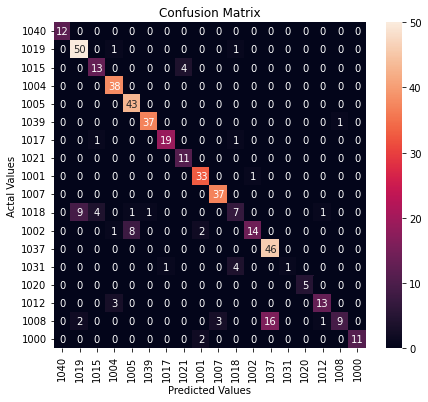

Confusion Matrix : Uncropped
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] (468,)
[[11  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  1 11  0  0  2  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 35  0  0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0 19  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 34  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  5 32  0  0  0  0  0  0  0  0]
 [ 0 17  1  1  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 1  0  0  4  2  0  0  3  7  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 45  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  3  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0]

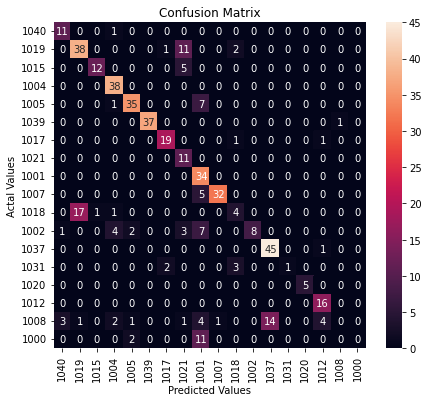

In [16]:
result(resnet_model_naug,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr)

# Augmentation


> 88.675
> 74.573
Cropped
[ 1  1  4 16 12 12  4  6 12  4  2  5  0  1  7  3 15  8  3  9 14  3  0 11
  1  9 12  3 10 10  9 15  1  5 11  6 12 12  1  5  6  5  7  4  3  9  2  1
  5  1  2  2 12  9  4  1  5 10  8 11  6  8  8  1  9  2  1  5 16 15  1  7
  3  4  3 11  4  8 10 12 12 15  1  9  1  9  6  1  5  5  9  7  4 12 11 11
 12 12 17  1  6  7 12 17  4  0  8  5  9 15  4  9 16 15  4 11  4  4 11  9
  4  3 11  9  1  4 12  1  4  4  6  6 10  8  6  1  1  5  5  8 12 11  4 15
 15  4  0  5  8 12  3  3 12  5 17 11  4 12  1  3 10  1  5 12  5 12  1  1
  4  1  6  9  4  4  4 14  1  8  5  9  5 12  3  6  5 17  1 13 12  8 10 12
  6  7 12 13  5  1  3 10 12 13  4  1  3  9 16  4  9  1 16  3  1 15 16  8
 12 16  9 11 12  1  1 10  6  3 12  0  4  8  9  6  2 12  5  9  4  5  4  2
  4  9 12  1  2 12 13  3 17 17  3  2  5  4  0 10 10 12 12  4  4  8  1 12
  9  5 12  1  1 17  5  9  8  6 15  3 11  2  3 16  3  1  3  1 12  3  1 16
 12  4 12 11  7  1  4 11  3  5  4  8  2  4 10  1  0  1 11  8  9  6 12  5
  4  6  3  3  1 17 15  4 

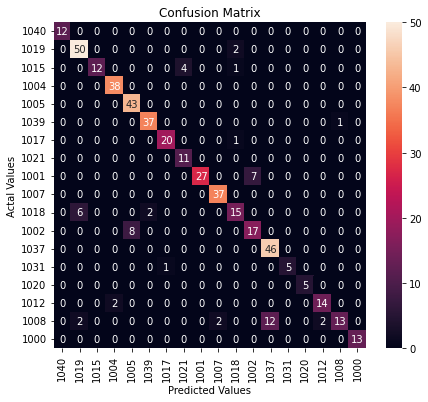

Confusion Matrix : Uncropped
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] (468,)
[[12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  1 10  0  0  5  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  5  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 34  0  0  0  7  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0 36  0  0  0  0  1  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0 14  0  0  0  5  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 32  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4 33  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  0  8  0  0  0  0  3  0  0]
 [ 1  0  0  4  0  0  0  0  9  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0 15  0  0]

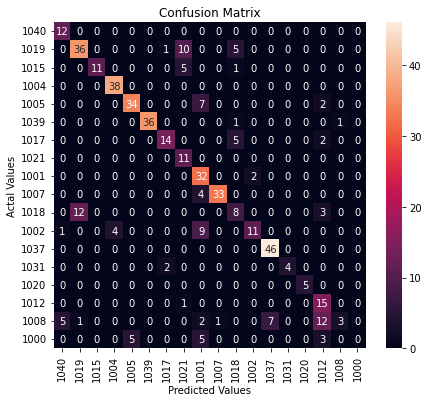

In [17]:
result(resnet_model_aug_1,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr) # default 

> 89.744
> 76.496
Cropped
[ 1  1  4 16 12 12  4  6 12  4  2  5  0  1  2  3 15  8  3  9 14  3  0 11
  1  8 12  3 10 10  9 15  1  5  8  6 12 12  1  5  6  5  7  4  3  9  2  1
  5  1  2  2 12  9  3  1  5 10  8 11  6  8  8  1  9  2  1  5  1 15  1  7
  3  4  3  8  4  8 10 12 12 15  1  9  1  9  6  1  5  5  9  7  4 12  8  8
 12 12 17  1  6  7 12 17  4  0  8  5  9 15  4  9 16 15  4 11  4  4  8  9
  4  3 11  9  1  4 12  1  4  4  6  6 10  8  6  1  1  5  5  8 12  8  4 15
 15  4  0  5  8 12  3  3 12  5 17 11  4 12  1  3 10  1  5 12  5 12  1  1
  4  1  6  9  4  4  4 14  1  8  5  9  5 12  3  6  5 17  1 13 12  8 10  1
  6  2 15 13  5  1  3 10  9 13  4  1  3  9 16  4  9  1 16  3 15 15 16  8
 12 16  9 11 12  1  1 10  6  3 12  0  4  8  9  6  2 12  5  9 11  5  4  2
  4  9 12  1  2  9 13  3 17 17  3  2  5  4  0 10 10 12  9  4  4  8  1 12
  9  5 12  1  1 17  5  9  8  6 15  3 11  2  3 16  3  1  3  1 12  3  1 16
 12  4 12  8  7  1  4 11  3  5  4  8  2  4  2  1  0  1 11  8  9  6 12  5
  4  6  3  3  1  8 15  4 

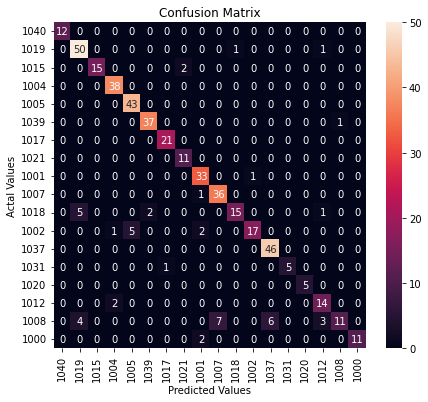

Confusion Matrix : Uncropped
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] (468,)
[[12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0 11  0  0  2  0  0  0  0  3  0  0]
 [ 0  0 11  0  0  0  0  5  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 35  0  0  0  6  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0 16  0  0  0  2  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0 34  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2 35  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0 11  0  0  0  0  4  0  0]
 [ 5  0  0  5  0  0  0  0  4  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 45  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  1  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0 15  0  0]

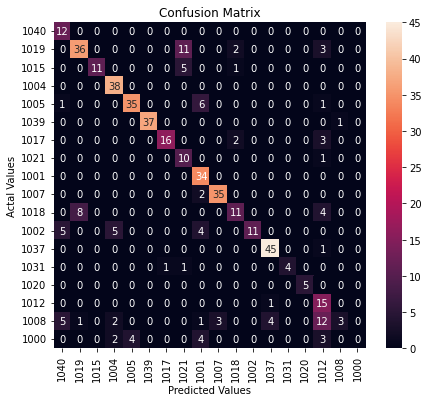

In [18]:
result(resnet_model_aug_2,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr) # only horizontal flip

> 4.487
> 5.128
Cropped
[ 6  6  0  2  2  2  0  2  2  0  2  2  2  0  2  2  2  2  0  2  2  2  0  2
  0  2  2  2  0  0  2  2  0  2  2  2 10  2  0  2  0  2  0 10  2  2  2  0
  2  0  0  2  2  2  0  0  2  0  2  2  2  2  2  0  2  2  0  2  6  0  0  2
  2  2  2  2  0  2  0 10  2  0  0  2  0  2  2  0  2  2  2  2  0  0  2  2
  2  2  0  0  6  0  2  2 10  0  2  2  2  0  2  2  2  0  0  2  0  2  2  2
  2  2  2  2  6  0 10  2  0  2  2  2  0  2  2  2  2  2  2  2  2  2  0  2
  2  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  6  0  0
  2  0  0  2  0  2 10  2  0  2  2  2  2  2  2  0  2  0  0  0  2  2  0  0
  2  2  2  0  2  0  2  0  2  2  0  0  2  2 10  0  2  0  6  2  0  2  2  2
  2  2  2  0  2  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  0  2  2  0  2  2  2  2  2  2  2  0  0  0  2  2  2  2  2  0  2
  2  2  2  0  0  2  2  2  2  2  0  2 10  2  2  6  0  0  2  0  2  0  0  6
  2  2  2  2  2  2 10  2  2  2  2  2  2  0  2 10  2  0  0  2  2  2  2  2
  0  2  2  2  2  2  2  2  0

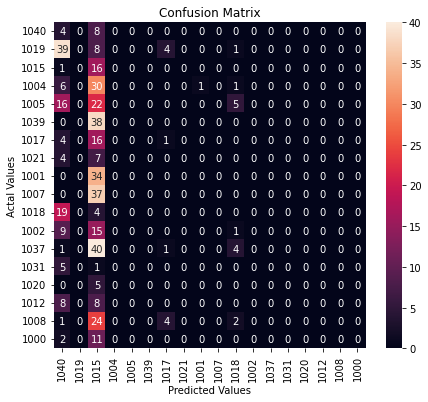

Confusion Matrix : Uncropped
[ 0  2  6  8 10] (468,)
[[ 7  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [33  0  6  0  0  0 12  0  1  0  0  0  0  0  0  0  0  0]
 [ 5  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [24  0  7  0  0  0  6  0  0  0  1  0  0  0  0  0  0  0]
 [32  0  2  0  0  0  5  0  0  0  4  0  0  0  0  0  0  0]
 [ 9  0 28  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [13  0  3  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  0  5  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [11  0 17  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 34  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [21  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [18  0  1  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0 31  0  0  0  3  0  0  0  9  0  0  0  0  0  0  0]
 [ 5  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [14  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [12  0 11  0  0  0  8  0  0  0  0 

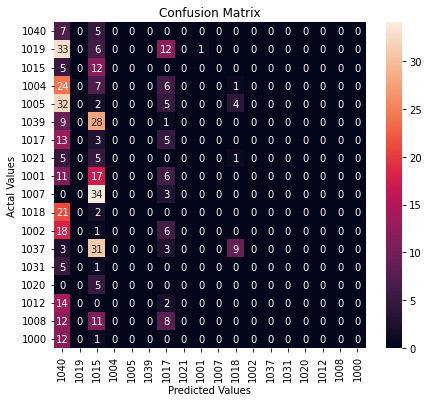

In [19]:
result(resnet_model_aug_3,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr) # horizontal, horizontal flip, standardization, width and height shift etc

> 90.812
> 72.863
Cropped
[ 1  1  4 16 12 12  4  6 12  4  2  5  0  1  2  3 15  8  3  9 14  3  0 11
  1  9 12 15 10 10  9 15  1  5 11  6 12 16  1  5  6  5  7  4  3  9  2  1
  5  1  2  2 12  9 11  7  5 10  8 11  6  8  8  1  9  2  1  5  1 15  1  7
  3  4  3  8 13  8 10 12 12 15  1  9  1  9  6  1  5  5 16  7  4 12 11  8
 12 12 17  1  6  7 12 17  4  0  8  5  9 15  4  9 16 15  4 11  4  4  8  9
  4  3 11  9  1 17 12  1 11  4  6  6 10  8  6  1  1  5  5  8 12  8  5 15
 15  4  0  5  8 12  3  3 12  5 17 11  4 12  1  3 10  1  5 12  5 12  1  1
  4  1  6  9  4  4  4 14  1 11  5  9  5 12  3  6  5 17  1  6 12  8 10  1
  6  2 12 13  5  1  3 10 12 13  4  1  3  9 16 11  9  1 16  3  1 16 16  8
 12 16  7 11 12  1  1 10  6  3 12  0  4  8  9  6  2 12  5  9 11  5  4  2
  4  9 12  1  2  7 13  3 17 17  3  2  5  4  0 10 10 12 16  4  4  8  1 12
  9  5 16  1  1 17  5  9  8  6 15  3 11  2  5 16  3  1  3  1 16  3  1 16
 12  4 12 11  7  1  4 11  3  5  4 11  2 11  2  1  0  1 11  8  9  6 12  5
  4  6  3  3  1 17 16  4 

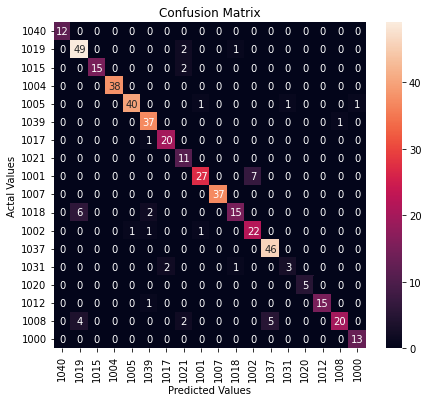

Confusion Matrix : Uncropped
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] (468,)
[[10  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0]
 [ 0 33  0  0  0  0  1 14  0  0  4  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  4  2  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 33  1  0  0  7  0  0  0  0  1  0  1  0  0]
 [ 0  0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0 17  0  0  0  2  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  1 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0 28  0  0  4  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  6 28  0  0  2  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  8  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0 42  0  0  3  0  0]
 [ 0  0  0  0  0  1  3  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0 15  0 

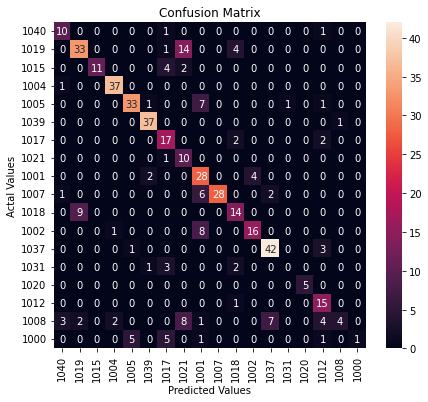

In [20]:
result(resnet_model_aug_4,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr) # horizontal, horizontal flip, standardization, width and height shift etc

# Augmentation + Discriminative Learning

In [21]:
resent_model_dsl = getResNet50Model_disc_learn()
# Augmentation + Discriminative Learning
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True) 
resent_model_dsl.fit(X_train_dg_4.flow(X_train, y_train), epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50, callbacks=[es]) 
 # horizontal flip, standardization, width and height shift etc

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

> 89.957
> 74.786
Cropped
[ 1  1  4 16 12 12  4  6 12  4  2  5  0  1  2  3  3  8  3  9 14  3  0 11
  1  8 12  3 10 10  9 15  1  5 11  6 12 12  1  5  6  5  7  4  3  9  2  1
  5  1  2  2 12  9 11  1  5 10  8 11  6  8  8  1  9  2 10  5  1 15 10  7
  3  4  3  8 13  8 10 12 12 15  1  9  1  9  6  1  5  5  9  7  4 12 11 11
 12 12 17  1  6  7 12 17  4  0  8  5  9 15  4  9 16 15  4 11 13  4  8  9
  4  3 11  9  1 17 12  1 11  4  6  6 10  8  6  1  1  5  5  8 12  8 11 15
 15  4  0  5  8 12  3  3 12  5 17 11  4 12  1  3 10  1  5 12  5 12  1  1
  4  1 13  9  4  4  4 14  1 11  5  9  5 12  3  6  5 17  1 13 12  8 10  1
  6  2 12 13  5  1  3 10  9 13  4  1  3  9 16 11  9  1 16  3 10 12 16  8
 12 16  9 11 12  1  1 10  6  3 12  0  4  8  9  6  2 12  5  9 11  5  4  2
  4  9 12  1  2 12 13  3 17 17  3  2  5  4  0 10 10 12  9  4  4  8  1 12
  9  5 12  1  1 17  5  9  8  6 15  3 11  2  3 16  3  1  3  1 12  3  1 16
 12  4 12  8  7  1  4 11  3  5  4 11  2 11 10  1  0  1 11  8  9  6 12  5
  4  6  3  3  1 17 12  4 

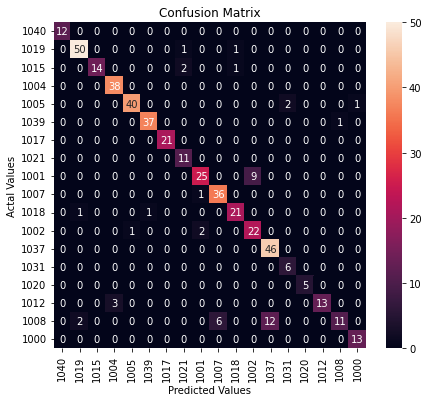

Confusion Matrix : Uncropped
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] (468,)
[[ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0]
 [ 0 35  0  0  0  0  1 10  0  0  6  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  1  3  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 34  0  0  0  5  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0 18  0  0  0  2  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 28  0  0  5  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  0  3 31  0  0  1  0  0  0  0  0]
 [ 0  4  1  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  7  0  1 13  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  1  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  1  0  0 14  0 

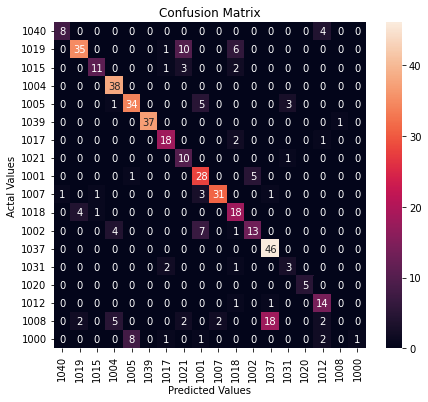

In [22]:
result(resent_model_dsl,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr) 